In [163]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

In [164]:
with open('./pickles/allPixelNDVIPoly.pickle', 'rb') as handle:
    allPixelNDVIPoly3 = pickle.load(handle)

with open('./pickles/newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

In [165]:
# Numero di cluster 

num_cluster = 2

allPixelNDVIPoly3 = allPixelNDVIPoly3[(newResa3<=11000) & (newResa3 >= 4000),:]
newResa3 = newResa3[(newResa3<=11000) & (newResa3 >= 4000)]

# Andiamo a calcolare una nuova metrica di coesione

In [166]:
km_one3 = TimeSeriesKMeans(n_clusters=num_cluster, metric="euclidean", max_iter=100,random_state=0)
y_pred_one3 = km_one3.fit_predict(allPixelNDVIPoly3)

In [167]:
print(np.unique(y_pred_one3))
print(y_pred_one3.shape)
print(newResa3.shape[0])

[0 1]
(1471,)
1471


In [168]:
label_3 = np.ndarray([newResa3.shape[0]])

for a,b in zip(newResa3,range(newResa3.shape[0])):
    if(a > 7000):
        label_3[b] = int(0) # resa alta
    else:
        label_3[b] = int(1) # resa bassa

In [169]:
print(label_3[y_pred_one3 == 0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.

In [170]:
# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(num_cluster):
    cluster_samples = allPixelNDVIPoly3[y_pred_one3 == i]
    cluster_classes = label_3[y_pred_one3 == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [171]:
print(cluster_class_mapping)

{0: 1.0, 1: 0.0}


In [172]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

for i in range(num_cluster):
    if(i != cluster_class_mapping[i]):

        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [173]:
indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_pred_one3))
    if y_pred_one3[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_pred_one3[a] = true_value

In [174]:
# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(num_cluster):
    cluster_samples = allPixelNDVIPoly3[y_pred_one3 == i]
    cluster_classes = label_3[y_pred_one3 == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [175]:
print(cluster_class_mapping)

{0: 0.0, 1: 1.0}


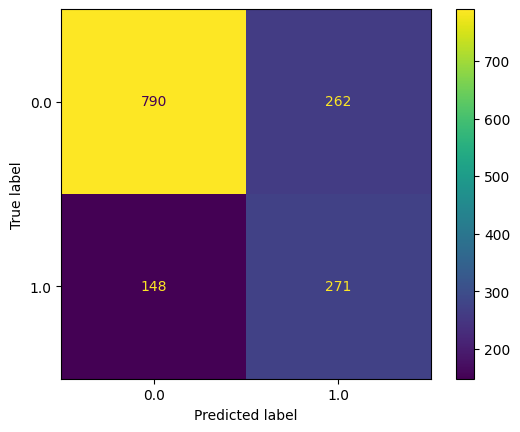

In [176]:
ConfusionMatrixDisplay.from_predictions(label_3,y_pred_one3)
plt.show()

In [177]:
accuracy_som = str(accuracy_score(label_3,y_pred_one3))
precision_som = str(precision_score(label_3,y_pred_one3,average='macro'))
recall_som = str(recall_score(label_3,y_pred_one3,average='macro'))

print("accuratezza " + accuracy_som)
print("precision " + precision_som)
print("recall " + recall_som)

accuratezza 0.7212780421481985
precision 0.6753301303719943
recall 0.6988643066508162
